In [1]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 107.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10

In [2]:
!pip install optuna

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts.models import TFTModel
from darts import TimeSeries
from darts.metrics import rmse
from darts.explainability import TFTExplainer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from darts.dataprocessing.transformers import Scaler
import itertools
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


In [86]:
from darts import TimeSeries

# Read and fix data
df = pd.read_csv("/kaggle/input/dummydata/electricity.csv", index_col='ds', parse_dates=True)
df = df[~df.index.duplicated(keep='first')]  # Remove duplicates

# Create TimeSeries
series = TimeSeries.from_dataframe(df, value_cols='y', fill_missing_dates=True, freq='h')

# Handle covariates
X_past = df[['Exogenous1', 'Exogenous2']]
covariates = TimeSeries.from_dataframe(X_past, fill_missing_dates=True, freq='h')

In [87]:
df.head(20)

,unique_id,y,Exogenous1,Exogenous2
ds,,,,
2016-10-22 00:00:00,BE,70.00,49593.0,57253.0
2016-10-22 01:00:00,BE,37.10,46073.0,51887.0
2016-10-22 02:00:00,BE,37.10,44927.0,51896.0
2016-10-22 03:00:00,BE,44.75,44483.0,48428.0
2016-10-22 04:00:00,BE,37.10,44338.0,46721.0
2016-10-22 05:00:00,BE,35.61,44504.0,46303.0
2016-10-22 06:00:00,BE,34.55,45005.0,48298.0
2016-10-22 07:00:00,BE,50.49,45602.0,51071.0
2016-10-22 08:00:00,BE,61.55,47063.0,54080.0


In [88]:
future_df = pd.read_csv('/kaggle/input/dummydata/electricity-future.csv', index_col='ds', parse_dates=True)
future_df = future_df[~future_df.index.duplicated(keep='first')]  # Remove duplicates

X_future = future_df[['Exogenous1', 'Exogenous2']]


X = pd.concat([X_past, X_future])

future_covariates = TimeSeries.from_dataframe(X, fill_missing_dates=True, freq='H')

'H' is deprecated and will be removed in a future version, please use 'h' instead.


In [89]:
future_df.head(20)

,unique_id,Exogenous1,Exogenous2
ds,,,
2016-12-31 00:00:00,BE,64108.0,70318.0
2016-12-31 01:00:00,BE,62492.0,67898.0
2016-12-31 02:00:00,BE,61571.0,68379.0
2016-12-31 03:00:00,BE,60381.0,64972.0
2016-12-31 04:00:00,BE,60298.0,62900.0
2016-12-31 05:00:00,BE,60339.0,62364.0
2016-12-31 06:00:00,BE,62576.0,64242.0
2016-12-31 07:00:00,BE,63732.0,65884.0
2016-12-31 08:00:00,BE,66235.0,68217.0


In [92]:
# Handle missing values
df.fillna(method='ffill', inplace=True)  # Forward fill
df.fillna(method='bfill', inplace=True)  # Backward fill any remaining

# Remove any infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


## Viewing the Data

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
from darts import TimeSeries

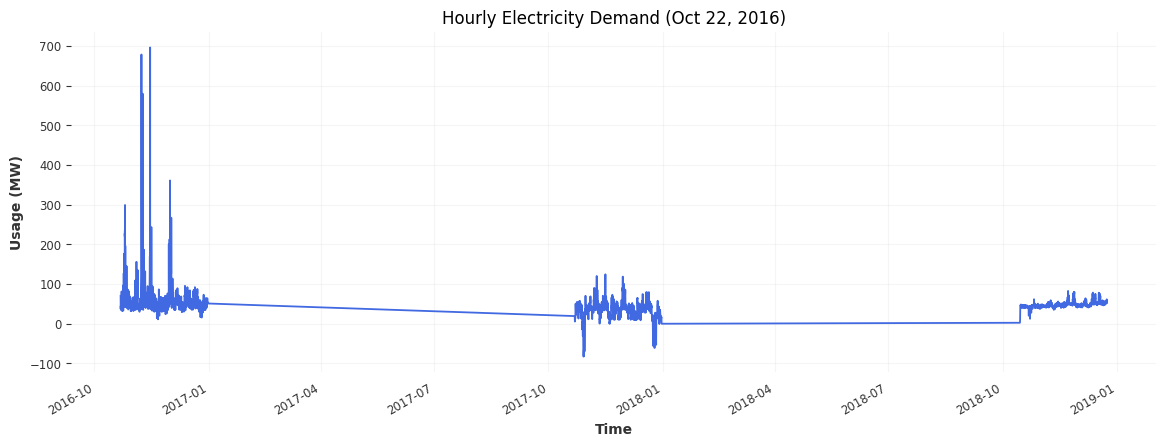

In [94]:
plt.figure(figsize=(14, 5))
df['y'].plot(title='Hourly Electricity Demand (Oct 22, 2016)', 
            xlabel='Time', 
            ylabel='Usage (MW)',
            color='royalblue')
plt.grid(True, alpha=0.3)
plt.show()

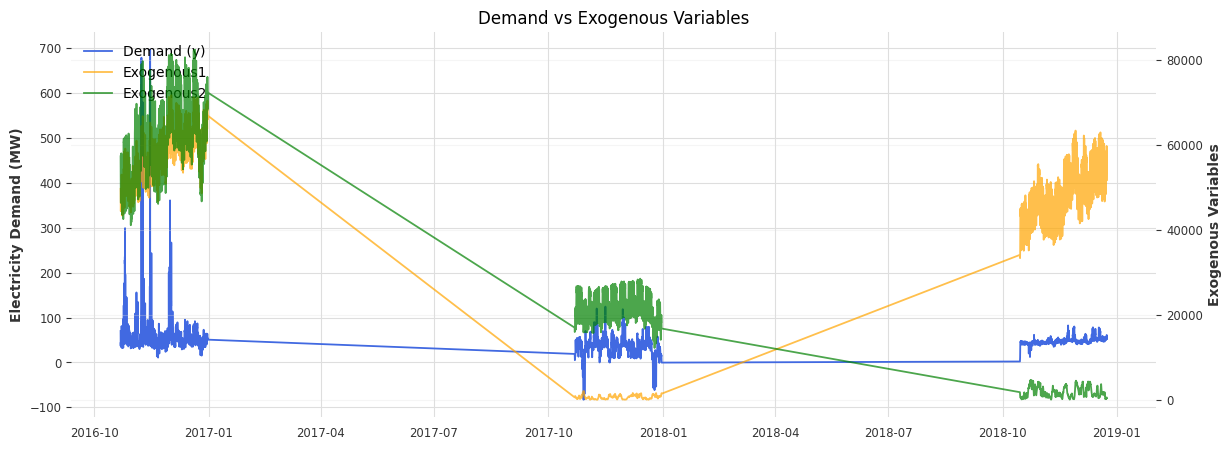

In [95]:
fig, ax1 = plt.subplots(figsize=(14, 5))

ax1.plot(df.index, df['y'], color='royalblue', label='Demand (y)')
ax1.set_ylabel('Electricity Demand (MW)')
ax2 = ax1.twinx()
ax2.plot(df.index, df['Exogenous1'], color='orange', alpha=0.7, label='Exogenous1')
ax2.plot(df.index, df['Exogenous2'], color='green', alpha=0.7, label='Exogenous2')
ax2.set_ylabel('Exogenous Variables')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Demand vs Exogenous Variables')
plt.grid(True, alpha=0.3)
plt.show()

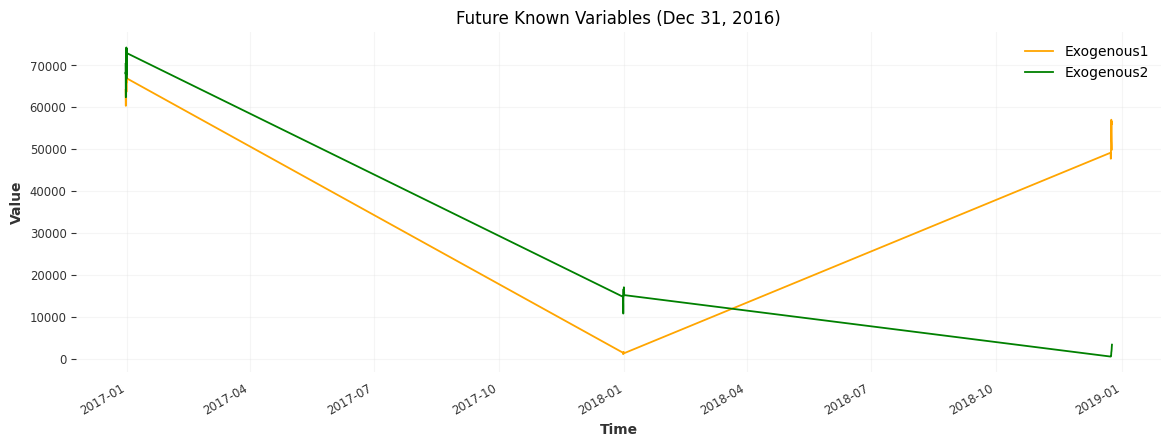

In [96]:
future_df[['Exogenous1', 'Exogenous2']].plot(
    figsize=(14, 5),
    title='Future Known Variables (Dec 31, 2016)',
    style=['orange', 'green'],
    xlabel='Time',
    ylabel='Value'
)
plt.grid(True, alpha=0.3)
plt.show()

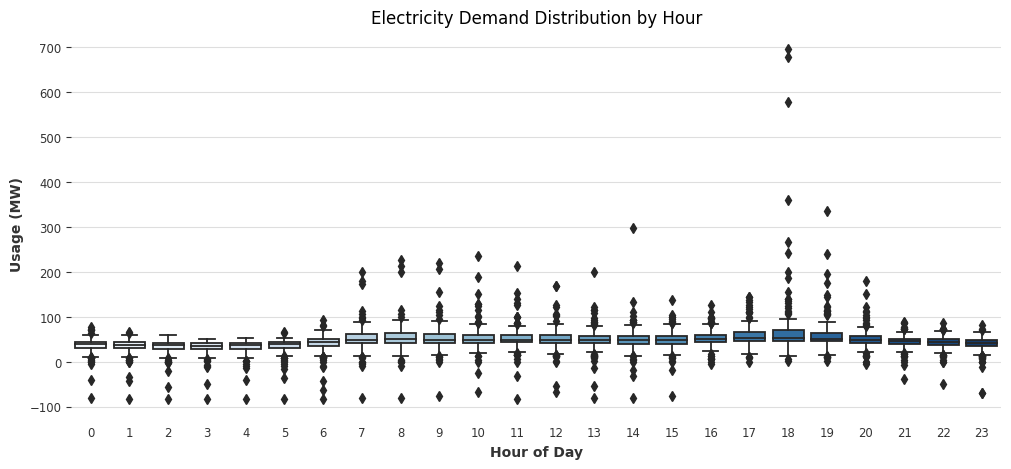

In [97]:
plt.figure(figsize=(12, 5))
sns.boxplot(x=df.index.hour, y=df['y'], palette='Blues')
plt.title('Electricity Demand Distribution by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Usage (MW)')
plt.show()

invalid value encountered in less


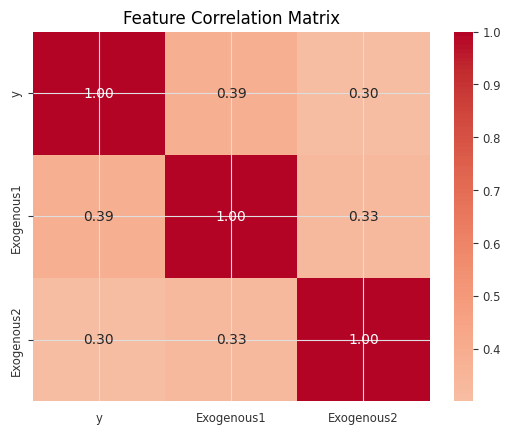

In [98]:
corr = df[['y', 'Exogenous1', 'Exogenous2']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

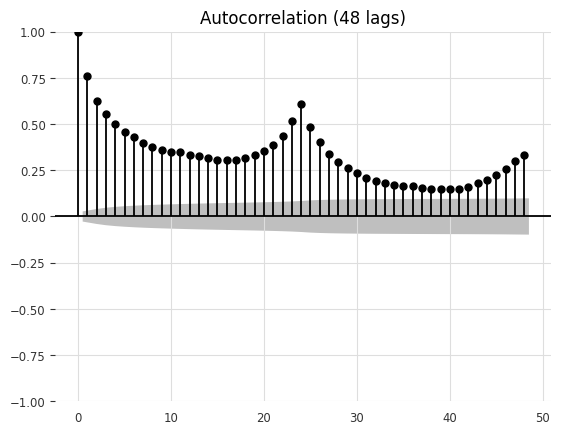

In [99]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['y'].dropna(), lags=48, title='Autocorrelation (48 lags)')
plt.show()

## Normalization for Training

In [100]:
scaler1, scaler2 = Scaler(), Scaler()
y_transformed = scaler1.fit_transform(series)
past_covariates_transformed = scaler2.fit_transform(covariates)
future_covariates_transformed = scaler2.transform(future_covariates)

In [101]:
print(y_transformed)

<TimeSeries (DataArray) (ds: 19032, component: 1, sample: 1)> Size: 152kB
array([[[0.19644187]],

       [[0.15421149]],

       [[0.15421149]],

       ...,

       [[0.17589146]],

       [[0.17572459]],

       [[0.17374785]]])
Coordinates:
  * ds         (ds) datetime64[ns] 152kB 2016-10-22 ... 2018-12-23T23:00:00
  * component  (component) <U1 4B 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None


In [102]:
print(past_covariates_transformed)

<TimeSeries (DataArray) (ds: 19032, component: 2, sample: 1)> Size: 305kB
array([[[0.69254836],
        [0.69557393]],

       [[0.64338292],
        [0.63032588]],

       [[0.62737621],
        [0.63043531]],

       ...,

       [[0.78189818],
        [0.00521644]],

       [[0.75879601],
        [0.00438959]],

       [[0.72168448],
        [0.00391537]]])
Coordinates:
  * ds         (ds) datetime64[ns] 152kB 2016-10-22 ... 2018-12-23T23:00:00
  * component  (component) <U10 80B 'Exogenous1' 'Exogenous2'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None


In [103]:
print(future_covariates_transformed)

<TimeSeries (DataArray) (ds: 19056, component: 2, sample: 1)> Size: 305kB
array([[[0.69254836],
        [0.69557393]],

       [[0.64338292],
        [0.63032588]],

       [[0.62737621],
        [0.63043531]],

       ...,

       [[0.71901669],
        [0.03489786]],

       [[0.71119492],
        [0.03732977]],

       [[0.69668273],
        [0.0396036 ]]])
Coordinates:
  * ds         (ds) datetime64[ns] 152kB 2016-10-22 ... 2018-12-24T23:00:00
  * component  (component) <U10 80B 'Exogenous1' 'Exogenous2'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None


In [104]:
print("Scaled stats - Target:")
print(f"Mean: {y_transformed.values().mean():.2f}, Std: {y_transformed.values().std():.2f}")
print("Scaled stats - Covariates:")
print(f"Mean: {past_covariates_transformed.values().mean():.2f}, Std: {past_covariates_transformed.values().std():.2f}")

Scaled stats - Target:
Mean: nan, Std: nan
Scaled stats - Covariates:
Mean: nan, Std: nan


In [105]:
print(np.isnan(y_transformed.values()).sum())
print(np.isnan(past_covariates_transformed.values()).sum())

13992
27984


In [106]:
from darts.dataprocessing.transformers import MissingValuesFiller

filler = MissingValuesFiller()
series_filled = filler.transform(series)
covariates_filled = filler.transform(covariates)
future_covariates_filled = filler.transform(future_covariates)

In [107]:
scaler1 = Scaler()
scaler2 = Scaler()

y_transformed = scaler1.fit_transform(series_filled)
past_covariates_transformed = scaler2.fit_transform(covariates_filled)
future_covariates_transformed = scaler2.transform(future_covariates_filled)

In [108]:
print("Scaled stats - Target:")
print(f"Mean: {y_transformed.values().mean():.2f}, Std: {y_transformed.values().std():.2f}")
print("Scaled stats - Covariates:")
print(f"Mean: {past_covariates_transformed.values().mean():.2f}, Std: {past_covariates_transformed.values().std():.2f}")

Scaled stats - Target:
Mean: 0.14, Std: 0.03
Scaled stats - Covariates:
Mean: 0.37, Std: 0.28


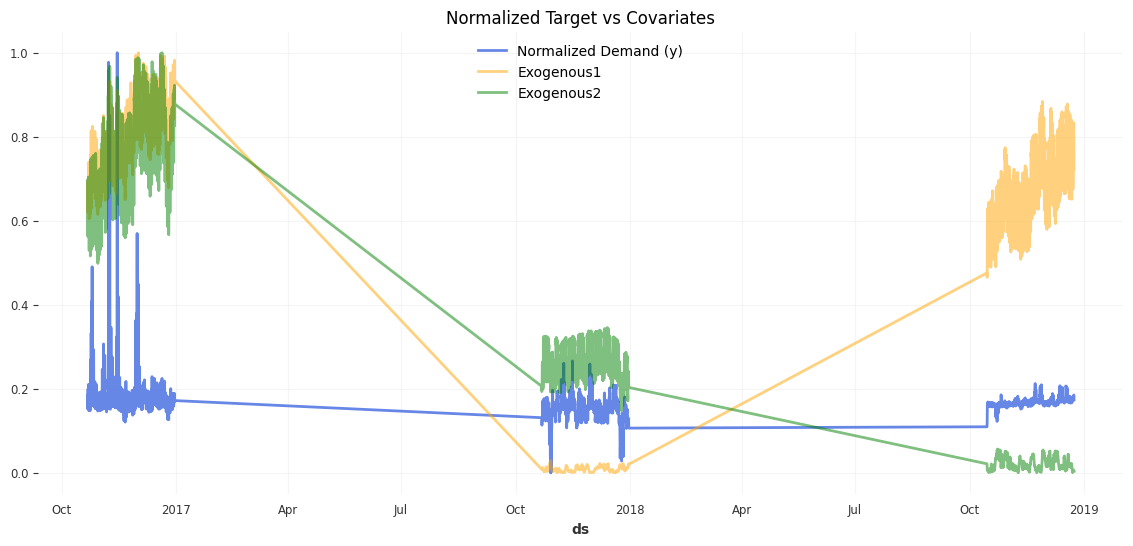

In [109]:
from darts.utils.missing_values import fill_missing_values

plt.figure(figsize=(14, 6))

# Plot target
y_transformed.plot(label='Normalized Demand (y)', color='royalblue', alpha=0.8)

# Plot covariates (on same axis - darts doesn't support twinx)
past_covariates_transformed['Exogenous1'].plot(label='Exogenous1', color='orange', alpha=0.5)
past_covariates_transformed['Exogenous2'].plot(label='Exogenous2', color='green', alpha=0.5)

plt.title('Normalized Target vs Covariates')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

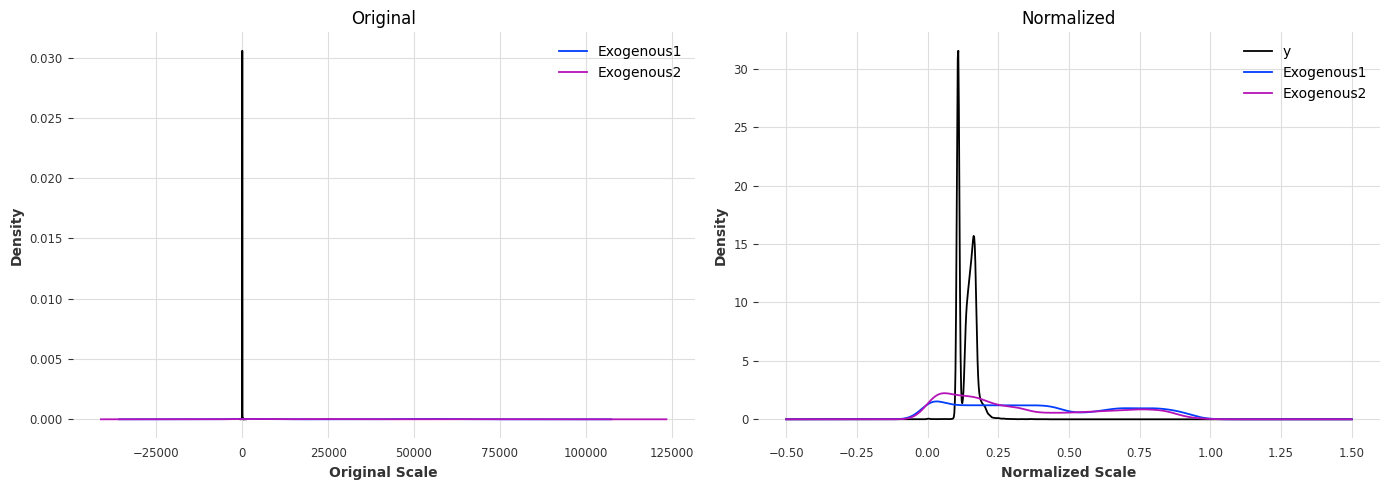

In [110]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Before scaling
df['y'].plot(kind='kde', ax=ax1, title='Original')
df[['Exogenous1','Exogenous2']].plot(kind='kde', ax=ax1)

# After scaling
pd.DataFrame({
    'y': y_transformed.values().flatten(),
    'Exogenous1': past_covariates_transformed.values()[:,0],
    'Exogenous2': past_covariates_transformed.values()[:,1]
}).plot(kind='kde', ax=ax2, title='Normalized')

ax1.set_xlabel('Original Scale')
ax2.set_xlabel('Normalized Scale')
plt.tight_layout()
plt.show()

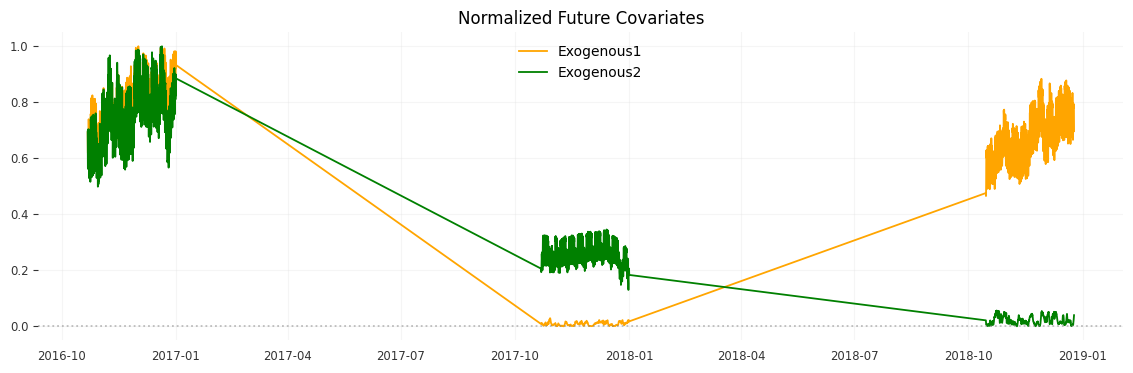

In [111]:
plt.figure(figsize=(14, 4))
plt.plot(future_covariates_transformed.time_index, 
         future_covariates_transformed.values()[:,0],
         label='Exogenous1',
         color='orange')

plt.plot(future_covariates_transformed.time_index, 
         future_covariates_transformed.values()[:,1],
         label='Exogenous2',
         color='green')

plt.title('Normalized Future Covariates')
plt.axhline(0, color='gray', linestyle=':', alpha=0.5)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Hyperparameter Tuning using `OPTUNA`

In [112]:
# Define function for Optuna
def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 16, 128)
    lstm_layers = trial.suggest_int("lstm_layers", 1, 4)
    num_attention_heads = trial.suggest_int("num_attention_heads", 2, 8)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    n_epochs = 5

    # Create TFT Model
    model = TFTModel(
        input_chunk_length=96,
        output_chunk_length=24,
        hidden_size=hidden_size,
        lstm_layers=lstm_layers,
        num_attention_heads=num_attention_heads,
        dropout=dropout,
        batch_size=batch_size,
        n_epochs=n_epochs,
        add_encoders={'cyclic': {'future': ['hour', 'day', 'month']}},
        use_static_covariates=True,
        pl_trainer_kwargs={"accelerator": "gpu" if torch.cuda.is_available() else "cpu", "devices": 1},
    )

    # Training
    model.fit(y_transformed, past_covariates_transformed, 
      future_covariates_transformed)

    # Validation with Historical Data
    cv = model.historical_forecasts(
        y_transformed,
        past_covariates_transformed,
        future_covariates_transformed,
        forecast_horizon=24,
        start=df.shape[0] - 10*24,
        stride=24,
        retrain=True
    )

    # RMSE Calculation
    rmse_value = np.mean([
        np.sqrt(mean_squared_error(df.y[pred.index], 
        scaler1.inverse_transform(pred).pd_series())) for pred in cv
    ])
    # Minimize RMSE
    return rmse_value

In [ ]:
import optuna

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=3)

print(f"Best RMSE: {study.best_value}")

best_params = study.best_params
print("\nFor final model, use these parameters with more epochs (e.g., 30-50)")
print(f"Best Parameters: {study.best_params}")

[I 2025-05-01 07:46:09,948] A new study created in memory with name: no-name-199aa632-70fe-423b-b031-3f9558967f53


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
best_params

## Training

In [58]:
best_params = study.best_params

final_model = TFTModel(
    input_chunk_length=best_params["input_chunk_length"],
    output_chunk_length=best_params["output_chunk_length"],
    hidden_size=best_params["hidden_size"],
    lstm_layers=best_params["lstm_layers"],
    num_attention_heads=best_params["num_attention_heads"],
    dropout=best_params["dropout"],
    batch_size=best_params["batch_size"],
    n_epochs=50,
    add_encoders={'cyclic': {'future': ['hour', 'day', 'month']}},
    use_static_covariates=True,
    optimizer_kwargs={"lr": best_params["learning_rate"]},  # This goes here, not in pl_trainer_kwargs
    pl_trainer_kwargs={
        "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
        "devices": 1,
        "gradient_clip_val": 0.5,
    }
)

final_model.fit(y_transformed, past_covariates_transformed, future_covariates_transformed)

Training: |          | 0/? [00:00<?, ?it/s]

NameError: name 'exit' is not defined

In [40]:
final_model.save("/kaggle/working/tft_electricity_final_model.pth")

In [42]:
# Forecasting
forecast = final_model.predict(
  n=24,
  past_covariates=past_covariates_transformed,
  future_covariates=future_covariates_transformed
)

Predicting: |          | 0/? [00:00<?, ?it/s]

In [44]:
print(forecast)

<TimeSeries (DataArray) (ds: 24, component: 1, sample: 1)> Size: 192B
array([[[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

...

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]]])
Coordinates:
  * ds         (ds) datetime64[ns] 192B 2018-12-24 ... 2018-12-24T23:00:00
  * component  (component) object 8B 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None
